In [1]:
from reservoir import ESN
from misc import *
import numpy as np
import time
import SYCLOP_env as syc
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
class  Syclop_Teacher:
    def __init__(self):
        self.hp = HP()
        self.hp.dt = 0.1
        self.hp.omega0 = 2*np.pi / 10.
        self.hp.A = 5.0 #target amplitude of oscillations. Target max speed is hence omega*A
        self.hp.noi = 0.01
        self.speed_lim = self.hp.omega0 * self.hp.A
        self.vel = 0
    def step(self,dvs_strip):        
        dvs_strip = dvs_strip + self.hp.noi*np.random.normal(size=np.shape(dvs_strip))
        I = dvs_strip**2.0
        I = I/(np.sum(I)+1e-10)
        centre = np.sum(I*np.array(range(len(dvs_strip))))- len(dvs_strip)/2.0 
        print('centre:',centre)
        self.vel += self.hp.dt*self.hp.omega0*centre 
        self.vel = self.vel if np.abs(self.vel)<self.speed_lim else self.speed_lim*np.sign(self.vel)


In [3]:
class Edge_Mover(syc.Scene):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.reset()
#         self.wave = [super().maxx//2]
        self.wave = [self.maxx//2]
    def reset(self):
        self.step = 0 
    def load_wave(self,wave):
        self.wave = wave
    def update(self): 
        self.step += 1
        self.edge_image_x(self.wave[self.step if self.step < len(self.wave) else -1])

In [4]:
def local_observer(sensor,agent):
    return np.concatenate([sensor.dvs_view[5,:].reshape([-1]),agent.qdot])
A = 1
A0 = 0
t_vec = np.array(list(range(1000)))
f_vec = np.sin(2*np.pi*t_vec/30.0)

In [5]:
    hp=HP()
    hp.max_episode = 3000
    hp.steps_per_episode = 4000
    hp.steps_between_learnings = 1000
    sceney,scenex  = 28,300

    recorder = Recorder(n=6)
    vertical_edge_mat = np.zeros([sceney,scenex])
    vertical_edge_mat[:,int(vertical_edge_mat.shape[1]/2):] = 1.0

    scene = Edge_Mover(image_matrix=vertical_edge_mat)
    sensor = syc.Sensor()
    agent = syc.Agent(max_q = [scene.maxx-sensor.hp.winx,scene.maxy-sensor.hp.winy])
    reward = syc.Rewards()
    esn = ESN(n_inputs = 52)

    esn.hp.g=1.5
    esn.reset()
    esn.wfb = esn.wfb*0.1

    hp.scene = scene.hp
    hp.sensor = sensor.hp
    hp.agent = agent.hp
    hp.reward = reward.hp


In [6]:
def pwl_to_wave(pwl):
    w_prev=[0,pwl[0][1]]
    wave =[]
    for w_this in pwl:
        wave += list(np.linspace(w_prev[1],w_this[1],max(w_this[0]-w_prev[0]+1,0)))[1:]
        w_prev = w_this
    return wave

In [11]:
wave1=pwl_to_wave([[0,150],[400,160],[900,145],[1350,190],[2000,100],[2400,110],[2600,80],[2800,110],[3300,115],[4000,160]])

In [12]:
scene.load_wave(wave1)

In [13]:
scene.reset()

In [14]:
teacher = Syclop_Teacher()

In [15]:
def run_period(this_recorder,teacher=None,scenario=None):
    observation = local_observer(sensor,agent)
    for step in range(hp.steps_per_episode):
        esn.step(uin = observation.reshape([-1,1]))
        scene.update()
        if training_on:
            teacher.step(observation.reshape([-1])[:-2])
            esn.FORCE_step(teacher.vel)
        agent.qdot[0] = A0+A*esn.z
#         agent.qdot[0] = A0+A*teacher.vel
        agent.act(None)
        sensor.update(scene,agent)
#         print( teacher.vel, agent.q)
        reward.update_rewards(sensor = sensor, agent = agent)
        observation_  = local_observer(sensor,agent) #todo: generalize
        this_recorder.record([agent.q_ana[0],agent.q[0],agent.qdot[0],reward.rewards[0],reward.rewards[1],reward.reward])
        observation = observation_
        step += 1

In [16]:
training_on = True
agent.q_ana = np.array([scenex/2.+3.,sceney/2.+3.])
agent.act(None)
run_period(recorder,teacher=teacher)

centre: -5.23462277840693
centre: 6.133328409146664
centre: 2.5519819862813833
centre: -4.351945813199038
centre: 1.1625124541746672
centre: -0.8251660359599384
centre: -1.2640732526773597
centre: -1.9728928180119318
centre: 0.770241650697983
centre: 0.2847278468128991
centre: 1.8150819425076357
centre: -4.179263296910712
centre: -2.699795210126723
centre: 1.1957825437243876
centre: -5.328533322928113
centre: 2.9130924123880746
centre: -24.89339261723908
centre: -24.447714104411123
centre: -23.457650897038068
centre: -21.421146735521774
centre: -18.479813269987957
centre: -14.452294082577422
centre: -9.938654458873861
centre: -6.495959354433438
centre: -3.508182989029841
centre: -0.5300538980632901
centre: 2.5132917869938645
centre: 5.436338200685668
centre: 8.471018030528704
centre: 11.515684428219316
centre: 13.934216886489914
centre: 15.95190120477104
centre: 17.44332492262125
centre: 0.03272035023794828
centre: 17.436231984892622
centre: 15.948001787013325
centre: 13.00513023093228

centre: -5.462310046744253
centre: -2.508541450075498
centre: 0.522783017872694
centre: 3.4737343684071647
centre: 6.48449125666907
centre: 9.48732738922687
centre: 11.466914895721892
centre: 12.481208961200863
centre: 13.466677284605112
centre: -3.106434685494097
centre: 12.977141533512672
centre: 11.455067599856875
centre: 9.957323434570021
centre: 7.4298786454907315
centre: 4.497372996548627
centre: 1.465605992143935
centre: -1.02277541411744
centre: -3.517213605600965
centre: -6.488350083285535
centre: -8.975117770063523
centre: -10.989548491714043
centre: -12.462174655173389
centre: -13.474803902980424
centre: -0.758421603892117
centre: -13.463152063738764
centre: -1.5445435272936514
centre: -12.45123078242153
centre: -10.963617339025822
centre: -8.502326431837151
centre: -5.482355454896648
centre: -2.50830102545887
centre: 0.9908222146319048
centre: 4.489714230964452
centre: 7.478993386034787
centre: 9.956174169206655
centre: 11.975765347024542
centre: 13.958586133722996
centre: 

centre: -1.501974743954527
centre: -4.028155266135567
centre: -6.478948748815384
centre: -9.494147901916746
centre: -11.973949157940112
centre: -1.6298668212248444
centre: -13.472374887801687
centre: -2.3758866528955487
centre: -13.457822879268315
centre: -12.461019990777286
centre: -10.973571092488934
centre: -8.96625660559188
centre: -6.486196524336542
centre: -3.991703001781069
centre: -0.9833867548325124
centre: 2.47975354994335
centre: 5.511460680803779
centre: 8.496819443147338
centre: 10.952590493959619
centre: 12.452736108552955
centre: 3.425309059850875
centre: -2.0323808581551823
centre: -0.2785758000431251
centre: 12.455603676724536
centre: 11.450032903474629
centre: 9.986249108586328
centre: 7.977047334856145
centre: 5.97986903974914
centre: 3.4736775524380654
centre: 0.47184648051579714
centre: -1.9897369655308097
centre: -4.491703531990694
centre: -7.479959678298901
centre: -9.462983306758975
centre: -10.982876382763262
centre: 2.624635095844777
centre: -12.47388822197826

centre: -12.461294700938947
centre: -11.47282849623638
centre: -10.467519199309262
centre: -8.960733975633278
centre: -6.470669577251289
centre: -3.5047928608397747
centre: -0.4887452006929287
centre: 2.48641635297221
centre: 5.485282297109286
centre: 8.464585666009228
centre: 10.987538592044828
centre: 12.464953099031767
centre: 13.47127931653177
centre: -0.7878737082024685
centre: 14.464288289314048
centre: 14.469782927242925
centre: 13.464311833356582
centre: 11.966603631949233
centre: 9.487435446965186
centre: 5.978305230995126
centre: 2.9966597071328245
centre: 0.5097670824835667
centre: -1.9888550108808367
centre: -4.503040570392702
centre: -6.9632963092262194
centre: -8.988476678259119
centre: -10.46968525277018
centre: -11.478397759575856
centre: -12.464089941925911
centre: -1.0658336682159337
centre: 0.2533377585016723
centre: -11.958346705019892
centre: -10.460392940914897
centre: -8.973566292035336
centre: -6.449919575435793
centre: -3.5133598537889092
centre: -0.52340310015

centre: 11.480482628452336
centre: 10.462654958944206
centre: 9.478241465388528
centre: 8.487443998110749
centre: 6.962194877064675
centre: 5.009919810049304
centre: 2.446827718984906
centre: -0.00825359507000556
centre: -2.959804726664462
centre: -6.477597772503579
centre: -9.016475756287102
centre: -10.485086354939591
centre: -1.6644942407608383
centre: 1.7376891631464169
centre: 1.4840818792563155
centre: -10.505183388492286
centre: -0.2880836772536064
centre: -9.468284977927203
centre: -8.468491750525171
centre: -7.488835578392429
centre: -6.484405712529728
centre: -5.471685902666724
centre: -3.9948896837072176
centre: -2.4905163125485146
centre: -0.9788090116272521
centre: 0.9867055222010457
centre: 2.501394919015855
centre: 3.9878791875322293
centre: 5.458175294214875
centre: 6.471781664271592
centre: -4.180952570097663
centre: 7.474776848383158
centre: -2.0751350109410325
centre: -4.002616489680161
centre: 0.26413952710924704
centre: 7.483696129994122
centre: -3.2446455025716254

centre: 13.462061013907423
centre: -0.5855292015429647
centre: 12.485038250349042
centre: 11.481334665351014
centre: 10.471951599605788
centre: 8.978577447412306
centre: 5.94795550027381
centre: 2.4722030823992434
centre: -0.9943097205381797
centre: -5.001124968595981
centre: -7.970591511525203
centre: -10.510082926804092
centre: -12.45794364365028
centre: -13.475330877637232
centre: 1.307796313228426
centre: -14.478092902378833
centre: -0.7515606104368544
centre: -13.958342949261132
centre: -11.941112519986044
centre: -9.987193950625675
centre: -7.470379992639302
centre: -4.99182956101988
centre: -2.9697697738997597
centre: -0.5271641128524074
centre: 2.986216707148877
centre: 6.516551269175565
centre: 8.978950825432634
centre: 10.97345905260535
centre: 12.46384529354453
centre: -1.2541178384581002
centre: 5.981412756046467
centre: 0.22047260578683847
centre: 0.9923759603769078
centre: 12.491284223303317
centre: 11.449750943364222
centre: 10.47992926305293
centre: 8.499962991762253
ce

centre: -14.467287337764372
centre: -13.45217850421857
centre: -12.482831043787623
centre: -10.950511585903351
centre: -8.450339101231158
centre: -4.962958447724169
centre: -1.4825554804370071
centre: 1.5330353560371606
centre: 4.475822650746338
centre: 7.491857165102452
centre: 10.522301947196269
centre: 13.507232465159746
centre: 15.447314734057628
centre: 16.467375554548674
centre: -2.7828682735769306
centre: 16.47150180977674
centre: 15.451605489577602
centre: 14.470507126963312
centre: 12.975396351428927
centre: 10.477998441388067
centre: 7.466738083141877
centre: 4.481815862851587
centre: 0.982304480520785
centre: -2.500042365056892
centre: -5.502009428982387
centre: -7.967206735749638
centre: -9.949612853341502
centre: -12.004143882369654
centre: -13.466322996594872
centre: -14.462820543008078
centre: -14.46261838570272
centre: -1.0955460676030242
centre: -12.973724324343218
centre: -10.976984296905467
centre: -7.955777573192172
centre: -4.502096709419082
centre: -1.502511995586

centre: -1.5027786386157267
centre: 1.5103809649657904
centre: 4.474329179737701
centre: 7.006491119962227
centre: 9.00134222449077
centre: 10.973475905788604
centre: 12.478704269668363
centre: -2.5743657556761548
centre: -3.297135367851549
centre: 12.471500320703775
centre: 11.463053217247086
centre: 10.475550901378618
centre: 8.958660690639341
centre: 6.967691215494959
centre: 5.011812619876366
centre: 2.4941681087248924
centre: -0.5010896547278882
centre: -3.5349752707703175
centre: -5.976736347099294
centre: -8.509275161803409
centre: -10.963003902216856
centre: -12.458593467300922
centre: -13.46757737643239
centre: -2.747289241338141
centre: 0.5314184404298068
centre: -13.448395536516447
centre: -12.460202997147922
centre: -11.46971806745436
centre: -9.971409430188247
centre: -7.4692693766988825
centre: -4.467198457589408
centre: -2.0249478377731904
centre: 0.4822715777699713
centre: 3.491922286262021
centre: 6.468996118568022
centre: 9.006066579425017
centre: 10.94768810556635
ce

centre: -12.963721501851321
centre: 3.930506351408887
centre: -1.1461833439698346
centre: -5.066544403205622
centre: -2.233948146250629
centre: -3.670308195801905
centre: -13.484829128341282
centre: -12.4738935923237
centre: -10.503653545834625
centre: -7.998110546017372
centre: -5.476206286237616
centre: -2.4801060121786698
centre: 1.0157726155960027
centre: 4.506132269095389
centre: 6.995371933248027
centre: 9.458370207580344
centre: 11.98021633916236
centre: 13.47113151774208
centre: -3.9175996578954404
centre: 14.435328677782408
centre: -3.8949458821603606
centre: 14.476793786189347
centre: 2.604639072682332
centre: 13.472097654384164
centre: 11.969867194769172
centre: 9.978061172755567
centre: 6.99932571071254
centre: 3.501348040123954
centre: 0.5177697730423603
centre: -2.4959400392621482
centre: -5.5114531036145
centre: -8.463180832872606
centre: -10.473379638939454
centre: -11.49255021172565
centre: -1.3435828333820012
centre: -11.443904623595737
centre: -3.3784831901282892
cen

centre: 12.459477011000281
centre: -4.633979685872124
centre: -2.568590640713577
centre: 11.46950188740253
centre: 10.488003688009798
centre: 9.477310436786702
centre: 7.95450409903173
centre: 5.981566245932825
centre: 3.494120308387018
centre: 0.5206275406934715
centre: -2.4576967975793593
centre: -5.4837521620139
centre: -7.969603058621342
centre: -9.966496187217526
centre: -11.938352214636796
centre: -4.284982009869889
centre: 0.303164920348717
centre: -13.46161881466166
centre: -13.457225509447902
centre: -12.468376363906874
centre: -11.465765730163861
centre: -9.987988654696256
centre: -7.503900454348095
centre: -4.466383767716735
centre: -1.4775590795437061
centre: 1.5084113217278485
centre: 4.010461069557515
centre: 6.449373083135747
centre: 8.961322834385633
centre: 10.940242752092239
centre: 12.458497585436618
centre: 1.3229014848996172
centre: -6.485614118530549
centre: 1.2066960729504146
centre: 12.46226879416956
centre: -4.2882941515013115
centre: 11.482332980831139
centre:

centre: -8.973460020243113
centre: -6.965837248553822
centre: -4.484186115082398
centre: -1.495034812058325
centre: 1.5414134588953878
centre: 4.4974666069877145
centre: 7.465012540997847
centre: 10.514186247111283
centre: 12.9643397640818
centre: 14.990304864129428
centre: 0.37054040864346405
centre: 15.457187808004441
centre: 14.457328901974385
centre: 12.959450257254822
centre: 10.979853937744316
centre: 8.980703562914059
centre: 5.924714838681027
centre: 2.483883586390565
centre: -0.990676268604151
centre: -4.493066120022778
centre: -7.469482510117182
centre: -10.489535045995718
centre: -12.45865567129482
centre: -13.488147433714692
centre: -1.9987555602341303
centre: -13.461574317451939
centre: -3.805861573945311
centre: -0.31221310859024953
centre: -12.475546997953796
centre: -10.936696474233212
centre: -8.972378420536575
centre: -6.544710086987461
centre: -4.0043125694711925
centre: -1.4711786419896953
centre: 1.4708445352695456
centre: 4.960989397403921
centre: 7.99573761417346

centre: -9.988218814827569
centre: -8.499035906357737
centre: -6.994242094913037
centre: -5.013702758012045
centre: -2.482687315477058
centre: 0.44908468193412787
centre: 4.048245698115668
centre: 7.464819708321087
centre: 10.454379603102744
centre: 12.471858281710254
centre: 13.470185963404262
centre: 2.943569715883296
centre: 3.024399596661663
centre: -3.9428694788555916
centre: -1.9438087264763801
centre: 13.448849448755539
centre: 12.012929133924281
centre: 9.991560440529433
centre: 7.955062127283014
centre: 5.489018987441433
centre: 2.5012509719086573
centre: -0.4909251076023793
centre: -3.0019504552893643
centre: -5.490239704369767
centre: -7.999164618712761
centre: -9.989034527983986
centre: -11.970928262486616
centre: -3.5140619294643862
centre: -13.45680299867681
centre: -13.480505318843894
centre: -12.485045884871218
centre: 1.083053187961113
centre: -11.44302579438257
centre: -9.995133320713617
centre: -7.512291434607118
centre: -4.510128544678057
centre: -1.471486308577326


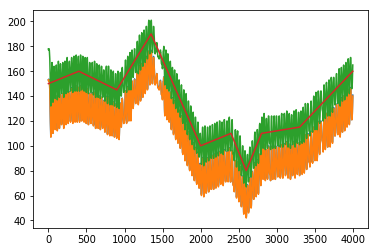

In [17]:
plt.figure()
plt.plot(recorder.records[0])
plt.plot(recorder.records[1])
plt.plot(np.array(recorder.records[1])+hp.winx//2)
plt.plot(scene.wave)

In [21]:
training_on = False

In [22]:
agent.q_ana = [scenex//2+sensor.hp.winx//2,2]
print(agent.q, agent.q_ana)
agent.act(None)
print(agent.q, agent.q_ana)

[17  2] [175, 2]
[175   2] [ 175.03382284    2.        ]


In [23]:
scenex//2+sensor.hp.winx//2

175

In [24]:
new_recorder = Recorder(n=6)

In [25]:
scene.reset()

In [29]:
scene.load_wave(pwl_to_wave([[0,280],[4000,150]]))
scene.load_wave(pwl_to_wave([[0,150],[4000,280]]))
scene.reset()
run_period(new_recorder)


<IPython.core.display.Javascript object>


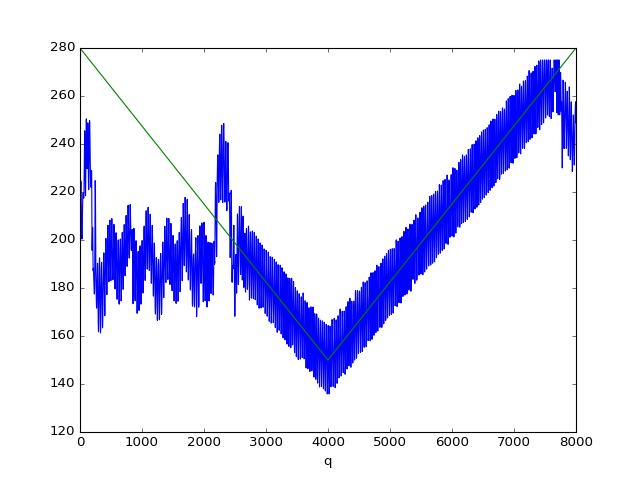

In [31]:
plt.figure()

plt.plot(np.array(new_recorder.records[0])+agent.hp.winx/2)
plt.plot(pwl_to_wave([[0,280],[4000,150]])+pwl_to_wave([[0,150],[4000,280]]))
plt.xlabel('q')


# plt.legend([str(uu) for uu in contrast_levels])

<IPython.core.display.Javascript object>


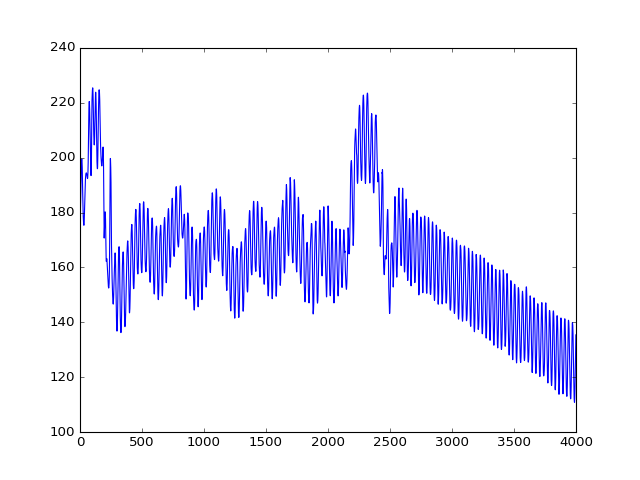

NameError: name 'contrast_levels' is not defined

In [28]:
plt.figure()
plt.plot(new_recorder.records[0])
plt.legend([str(uu) for uu in contrast_levels])
plt.xlabel('time')
plt.ylabel('q')
plt.title('contrast')
#plt.plot(scene.wave)

In [ ]:
plt.figure()
plt.plot(scene.wave)

In [ ]:
agent.q_ana = np.array([sceney/2.+3.,scenex/2.+3.])
agent.act(None)

In [ ]:
new_recorder2 = Recorder(n=6)
edge_placement = [150,160,170,180]    
for ii, ee in enumerate(edge_placement):    
    vertical_edge_mat = np.zeros([sceney,scenex])
    vertical_edge_mat[:,ee:] = 1
    scene = syc.Scene(image_matrix=vertical_edge_mat)
    run_period(new_recorder2)
    print(ii)

In [ ]:
plt.figure()
for chunk in range(5):
    plt.plot(new_recorder2.records[0][chunk*1000:(chunk+1)*1000],new_recorder2.records[2][chunk*1000:(chunk+1)*1000])
plt.xlabel('q')
plt.ylabel('dq/dt')
plt.title('location')
plt.legend([str(uu) for uu in edge_placement])

In [ ]:
plt.figure()
for chunk in range(5):
    plt.plot(list(range(chunk*1000,(chunk+1)*1000)),new_recorder2.records[0][chunk*1000:(chunk+1)*1000])
plt.legend([str(uu) for uu in edge_placement])
plt.title('location')
plt.xlabel('time')
plt.ylabel('q')

In [ ]:
plt.figure()
for chunk in range(5):
    plt.plot(new_recorder2.records[2][chunk*1000:(chunk+1)*1000],new_recorder2.records[3][chunk*1000:(chunk+1)*1000],'.')
plt.ylabel('intensity')
plt.xlabel('dq/dt')
plt.title('location')
plt.legend([str(uu) for uu in edge_placement])

In [ ]:
qdot_vec = np.linspace(-1.1,1.1,23)

In [ ]:
qdot_vec

In [ ]:
means=[]
for qdotmin,qdotmax in zip(qdot_vec[:-1],qdot_vec[1:]):
    qq= np.logical_and(np.array(new_recorder2.records[2])<=qdotmax,  np.array(new_recorder2.records[2])>=qdotmin)
    means.append(np.mean(np.array(new_recorder2.records[3])[qq]))

In [ ]:
len(np.array([12,12,12]))/2

In [ ]:
plt.plot(qdot_vec[:-1]+0.05,means,linewidth=3)

In [ ]:
plt.figure()
plt.plot(recorder.records[0])

In [ ]:
plt.figure()
plt.plot(recorder.records[0],recorder.records[3],'.')

In [ ]:
scenex/2.+3.

In [ ]:
vertical_edge_mat

In [ ]:
    def bubu(dvs_strip):        
        dvs_strip = dvs_strip + np.random.normal(size=np.shape(dvs_strip))
        I = dvs_strip**2.0
        I = I/(np.sum(I)+1e-10)
        centre = np.sum(I*np.array(range(len(dvs_strip))))- len(dvs_strip)/2.0 
        return centre

In [ ]:
bubu([0,0,0,0,1,0,0,0])

In [18]:
import pickle
with open('deleteme.pkl','rb') as f:
    uu=pickle.load(f)

In [21]:
uu.wfb[0]

array([0.52073469])